# Lead-time Prediction With CatBoost

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import sys
import os
sys.path.append(os.path.abspath(".."))

c:\Users\Sebastijan\anaconda3\envs\hotel_management\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Import

In [2]:
data = pd.read_parquet("../../data/hotel_booking_optimized.parquet")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


## Data Exploration

In [3]:
data["lead_time"].value_counts()

lead_time
0      6345
1      3460
2      2069
3      1816
4      1715
       ... 
400       1
370       1
532       1
371       1
463       1
Name: count, Length: 479, dtype: int64

## Preparing the Data

In [3]:
# A function to map week number to season
def week_to_season(week):
    if 10 <= week <= 21:
        return 'Spring'
    elif 22 <= week <= 34:
        return 'Summer'
    elif 35 <= week <= 47:
        return 'Fall'
    else:
        return 'Winter'

data["total_stay"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
data["arrival_season"] = data["arrival_date_week_number"].apply(week_to_season)

In [4]:
numeric_features = [
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults', 'children', 'babies',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'total_stay'
]

categorical_features = [
    'hotel',
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'deposit_type',
    'agent',
    'customer_type',
    'arrival_season'
]


In [5]:
for col in categorical_features:
    data[col] = data[col].astype(str).fillna('missing')

## Train/Test Split

In [6]:
X = data[numeric_features + categorical_features].copy()
y = data["lead_time"].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42
)  # 0.15 x 0.8 = 0.12   

## First Model

### Preparation

In [7]:
class SklearnCatBoost(CatBoostRegressor, BaseEstimator):
    pass

cb = SklearnCatBoost(
    loss_function="RMSE", 
    verbose=100, 
    random_seed=42,
    task_type="GPU",
    devices='0'
)

In [9]:
param_dist_1 = {
    'iterations': [500, 1000, 1500, 2000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.3, 0.7, 1],
    'random_strength': [0, 1, 3, 5, 10]
}

In [10]:
fit_params_1 = {
    'cat_features': categorical_features,
    'eval_set': (X_val, y_val),
    'early_stopping_rounds': 100,
    'use_best_model': True
}

In [11]:
random_search_1 = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_1,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

## Search

In [12]:
random_search_1.fit(X_train, y_train, **fit_params_1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 104.3379794	test: 104.5952117	best: 104.5952117 (0)	total: 112ms	remaining: 3m 43s
100:	learn: 64.1140248	test: 64.3135554	best: 64.3135554 (100)	total: 3.8s	remaining: 1m 11s
200:	learn: 60.9029625	test: 61.6231916	best: 61.6231916 (200)	total: 7.53s	remaining: 1m 7s
300:	learn: 59.0466116	test: 60.2616500	best: 60.2616500 (300)	total: 11.2s	remaining: 1m 3s
400:	learn: 57.6063282	test: 59.3807038	best: 59.3807038 (400)	total: 14.9s	remaining: 59.3s
500:	learn: 56.2683052	test: 58.6626629	best: 58.6626629 (500)	total: 18.5s	remaining: 55.3s
600:	learn: 55.2596433	test: 58.1648555	best: 58.1648555 (600)	total: 22s	remaining: 51.2s
700:	learn: 54.3234683	test: 57.6979811	best: 57.6979811 (700)	total: 25.6s	remaining: 47.5s
800:	learn: 53.4722496	test: 57.2769998	best: 57.2769998 (800)	total: 29.3s	remaining: 43.8s
900:	learn: 52.7820037	test: 57.0222044	best: 57.0222044 (900)	total: 32.9s	remaining: 40.2s
1000:	learn

,estimator,"SklearnCatBoo..., verbose=100)"
,param_distributions,"{'bagging_temperature': [0, 0.3, ...], 'depth': [4, 6, ...], 'iterations': [500, 1000, ...], 'l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [13]:
random_search_1.best_params_

{'random_strength': 3,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'iterations': 1500,
 'depth': 10,
 'bagging_temperature': 0.7}

In [14]:
cat_boost_1 = random_search_1.best_estimator_
cat_boost_1

,iterations,1500
,learning_rate,0.1
,depth,10
,l2_leaf_reg,3
,loss_function,'RMSE'
,random_seed,42
,verbose,100
,random_strength,3
,bagging_temperature,0.7
,task_type,'GPU'
,devices,'0'


### Evaluation

In [15]:
y_pred_1 = cat_boost_1.predict(X_test)

In [16]:
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae_1 = mean_absolute_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)

print("First model evaluation:")
print(f"RMSE: {rmse_1:.2f}")
print(f"MAE:  {mae_1:.2f}")
print(f"R²:   {r2_1:.3f}")

First model evaluation:
RMSE: 54.29
MAE:  36.03
R²:   0.741


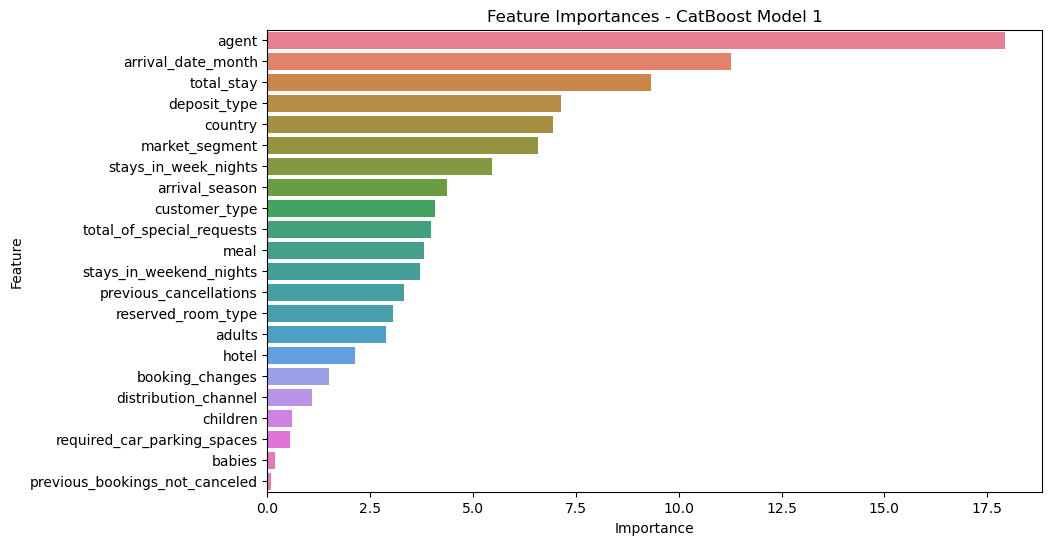

In [17]:
feature_importances_1 = cat_boost_1.get_feature_importance()
feature_names_1 = X_train.columns # not needed to change later, but for clarity

df_imp_1 = pd.DataFrame({
    'Feature': feature_names_1,
    'Importance': feature_importances_1
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_1, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model 1")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

In [18]:
df_imp_1

,Feature,Importance
19,agent,17.944042
12,arrival_date_month,11.262828
10,total_stay,9.325541
18,deposit_type,7.132841
14,country,6.931982
15,market_segment,6.568347
1,stays_in_week_nights,5.452499
21,arrival_season,4.376858
20,customer_type,4.083231
9,total_of_special_requests,3.985853


## Second Model

### Preparation

In [8]:
param_dist_2 = {
    'iterations': [1300, 1500, 1700],
    'depth': [9, 10],
    'learning_rate': [0.08, 0.1, 0.12, 0.15, 0.2],
    'l2_leaf_reg': [2, 3, 4],
    'bagging_temperature': [0.6, 0.7, 0.8],
    'random_strength': [2, 3, 4]
}

In [9]:
# same as before but rewritten for clarity
fit_params_2 = {
    'cat_features': categorical_features,
    'eval_set': (X_val, y_val),
    'early_stopping_rounds': 100,
    'use_best_model': True
}

In [10]:
random_search_2 = RandomizedSearchCV(
    estimator=cb,
    param_distributions=param_dist_2,
    n_iter=40, # refined search with more iterations
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1
)

### Search

In [11]:
random_search_2.fit(X_train, y_train, **fit_params_2)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
0:	learn: 101.1339894	test: 101.3278216	best: 101.3278216 (0)	total: 189ms	remaining: 4m 42s
100:	learn: 60.9115730	test: 61.7865790	best: 61.7865790 (100)	total: 3.4s	remaining: 47.1s
200:	learn: 57.0990541	test: 59.3076007	best: 59.3076007 (200)	total: 6.53s	remaining: 42.2s
300:	learn: 54.5314797	test: 57.9175264	best: 57.9175264 (300)	total: 9.77s	remaining: 38.9s
400:	learn: 52.5968622	test: 57.1716785	best: 57.1716785 (400)	total: 13s	remaining: 35.5s
500:	learn: 50.9813557	test: 56.6450155	best: 56.6450155 (500)	total: 15.9s	remaining: 31.7s
600:	learn: 49.3881293	test: 56.1279884	best: 56.1279884 (600)	total: 18.9s	remaining: 28.2s
700:	learn: 48.0689643	test: 55.8486523	best: 55.8486523 (700)	total: 21.9s	remaining: 24.9s
800:	learn: 46.7960026	test: 55.6208385	best: 55.6126660 (798)	total: 24.9s	remaining: 21.7s
900:	learn: 45.4040392	test: 55.2619150	best: 55.2572390 (898)	total: 28s	remaining: 18.6s
1000:	learn: 

,estimator,"SklearnCatBoo..., verbose=100)"
,param_distributions,"{'bagging_temperature': [0.6, 0.7, ...], 'depth': [9, 10], 'iterations': [1300, 1500, ...], 'l2_leaf_reg': [2, 3, ...], ...}"
,n_iter,40
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [12]:
random_search_2.best_params_

{'random_strength': 3,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'iterations': 1500,
 'depth': 10,
 'bagging_temperature': 0.8}

In [13]:
cat_boost_2 = random_search_2.best_estimator_
cat_boost_2

,iterations,1500
,learning_rate,0.1
,depth,10
,l2_leaf_reg,3
,loss_function,'RMSE'
,random_seed,42
,verbose,100
,random_strength,3
,bagging_temperature,0.8
,task_type,'GPU'
,devices,'0'


In [14]:
y_pred_2 = cat_boost_2.predict(X_test)

In [15]:
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

print("Second model evaluation:")
print(f"RMSE: {rmse_2:.2f}")
print(f"MAE:  {mae_2:.2f}")
print(f"R²:   {r2_2:.3f}")

Second model evaluation:
RMSE: 54.21
MAE:  35.97
R²:   0.742


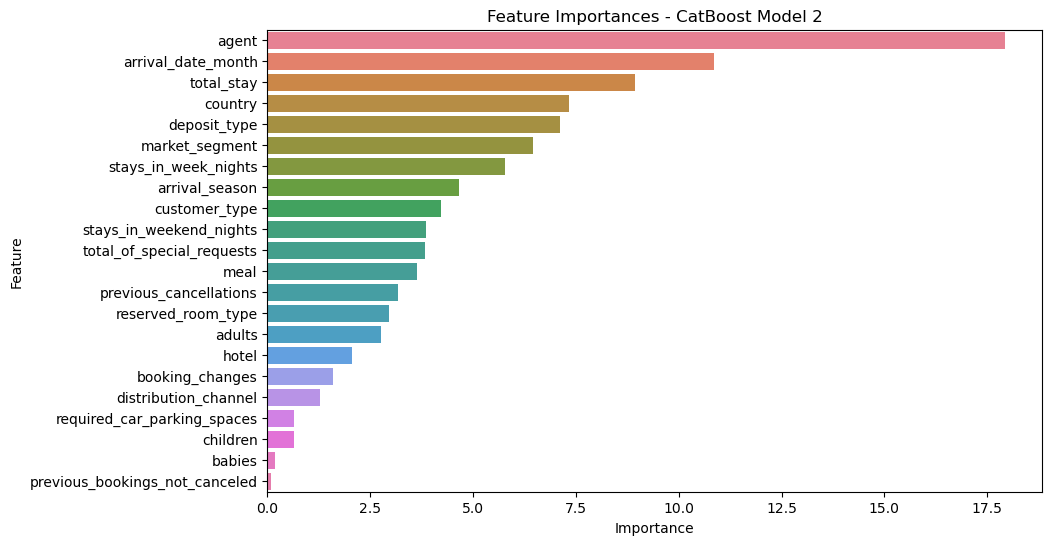

In [16]:
feature_importances_2 = cat_boost_2.get_feature_importance()
feature_names_2 = X_train.columns # redeclared for clarity

df_imp_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': feature_importances_2
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_2, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model 2")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

## Saving the Model and Other Relevant Data

### Retraining with train and val

In [8]:
final_model = CatBoostRegressor(
    loss_function="RMSE", 
    verbose=100,
    random_seed=42,
    task_type="GPU",
    devices='0',

    # best hyperparameters from the second search
    random_strength= 3,
    learning_rate= 0.1,
    l2_leaf_reg= 3,
    iterations= 1500,
    depth= 10,
    bagging_temperature= 0.8
)

In [9]:
final_model.fit(
    X_train_val, 
    y_train_val,
    cat_features=categorical_features,
    early_stopping_rounds=100,
)

0:	learn: 102.0161400	total: 125ms	remaining: 3m 7s
100:	learn: 59.5157404	total: 3.85s	remaining: 53.3s
200:	learn: 55.8035554	total: 7.54s	remaining: 48.7s
300:	learn: 53.7829547	total: 11.2s	remaining: 44.6s
400:	learn: 52.3327127	total: 14.8s	remaining: 40.5s
500:	learn: 50.7103436	total: 18.5s	remaining: 36.8s
600:	learn: 49.4374023	total: 22.2s	remaining: 33.2s
700:	learn: 48.3272775	total: 25.9s	remaining: 29.5s
800:	learn: 47.3002022	total: 29.6s	remaining: 25.9s
900:	learn: 46.3351541	total: 33.4s	remaining: 22.2s
1000:	learn: 45.4243082	total: 37.2s	remaining: 18.5s
1100:	learn: 44.5562293	total: 41s	remaining: 14.9s
1200:	learn: 43.8194714	total: 44.7s	remaining: 11.1s
1300:	learn: 43.0508007	total: 48.5s	remaining: 7.41s
1400:	learn: 42.2727270	total: 52.2s	remaining: 3.69s
1499:	learn: 41.5322003	total: 55.8s	remaining: 0us


### Saving the model

In [10]:
required_columns = numeric_features + categorical_features

required_columns = [c for c in required_columns if c not in ['arrival_season', 'total_stay']]

In [11]:
class LeadTimePredictor:
    def __init__(self, model, categorical_features, required_columns):
        self.model = model
        self.categorical_features = categorical_features
        self.required_columns = required_columns

    def week_to_season(self, week):
        if 10 <= week <= 21:
            return 'Spring'
        elif 22 <= week <= 34:
            return 'Summer'
        elif 35 <= week <= 47:
            return 'Fall'
        else:
            return 'Winter'

    def validate_schema(self, X):
        missing = [c for c in self.required_columns if c not in X.columns]
        if missing:
            raise ValueError(
                f"Model input schema violation. Missing columns: {missing}"
            )
        return X

    def _engineer_features(self, X):
        X = X.copy()
        X["total_stay"] = X["stays_in_weekend_nights"] + X["stays_in_week_nights"]
        X["arrival_season"] = X["arrival_date_week_number"].apply(self.week_to_season)
        for col in self.categorical_features:
            X[col] = X[col].astype(str).fillna('missing')
        return X

    def predict(self, X):
        X = self.validate_schema(X)
        X = self._engineer_features(X)
        return self.model.predict(X)

In [12]:
lead_time_predictor = LeadTimePredictor(
    model=final_model,
    categorical_features=categorical_features,
    required_columns=required_columns
)

In [13]:
joblib.dump(lead_time_predictor, "../../models/lead_time_predictor.joblib", compress=("lz4", 3))

['../../models/lead_time_predictor.joblib']

### Saving the feature importances

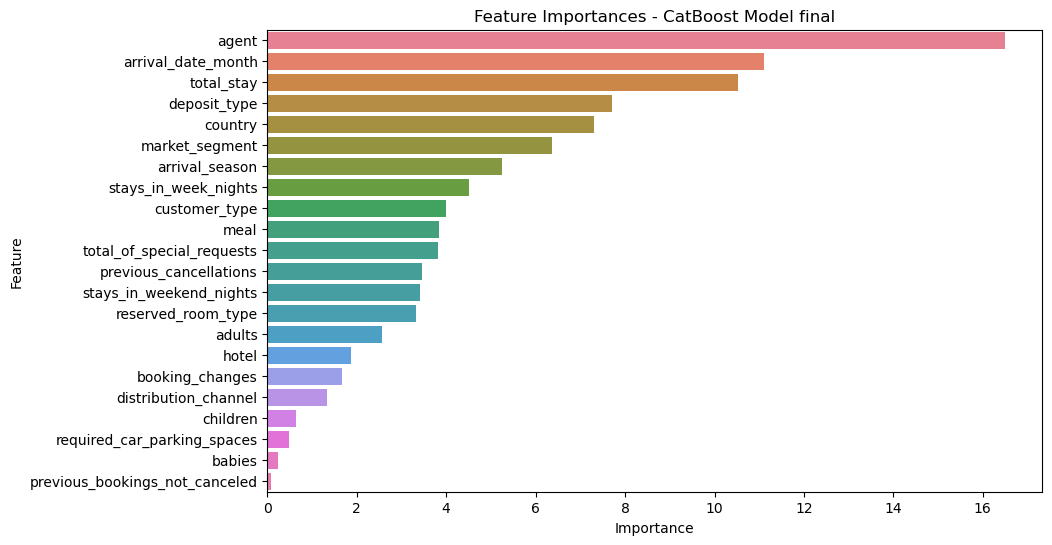

In [14]:
feature_importances_final = final_model.get_feature_importance()
feature_names_final = X_train_val.columns

df_imp_final = pd.DataFrame({
    'Feature': feature_names_final,
    'Importance': feature_importances_final
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp_final, hue="Feature", legend=False)
plt.title("Feature Importances - CatBoost Model final")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show();

In [16]:
df_imp_final.to_csv("../../models/lead_time_feature_importances.csv", index=False)

### Saving the shap values

In [17]:
explainer = shap.TreeExplainer(lead_time_predictor.model) # same as writing final_model
shap_values = explainer.shap_values(X_test)

In [18]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': mean_abs_shap
}).sort_values(by='SHAP_Importance', ascending=False)

shap_importance

,Feature,SHAP_Importance
19,agent,15.059727
12,arrival_date_month,12.123143
18,deposit_type,11.093079
10,total_stay,9.035783
15,market_segment,8.722329
14,country,7.580479
20,customer_type,5.781617
21,arrival_season,5.176171
1,stays_in_week_nights,4.241096
5,previous_cancellations,4.005102


In [19]:
shap_importance.to_csv("../../models/lead_time_regression_shap_values.csv", index=False)

## END OF FILE